## Visualization & Audio Examples 2 -- Using new helper functions

In [8]:
import sys
sys.path.append('..')
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
from einops import rearrange
from IPython.display import display, Audio
import textwrap

from msm_mae.runtime import RuntimeMAE


# Create runtime instance
weight = '../80x512p16x16_0425/checkpoint-100.pth'
runtime = RuntimeMAE(weight_file=weight)

80x512p16x16_0425
MaskedAutoencoderViT(patch size=(16, 16), grid_size=(5, 32),
  embed_dim=768, depth=12, num_heads=12, decoder_embed_dim=384,
  decoder_depth=4, decoder_num_heads=6, mlp_ratio=4,
  norm_pix_loss=False, use_cls_token=True, use_2d_dec_pos_embd=False)
Runtime MelSpectrogram(16000, 400, 400, 160, 80, 50, 8000):
MelSpectrogram(
  Mel filter banks size = (80, 201), trainable_mel=False
  (stft): STFT(n_fft=400, Fourier Kernel size=(201, 1, 400), iSTFT=False, trainable=False)
)


In [2]:
import torchaudio


class BaseRawAudioDataset(torch.utils.data.Dataset):
    def __init__(self, cfg, tfms=None, random_crop=False):
        self.cfg = cfg
        self.tfms = tfms
        self.random_crop = random_crop

    def __len__(self):
        raise Exception('implement me')

    def get_audio(self, index):
        raise Exception('implement me')

    def get_label(self, index):
        return None # implement me

    def __getitem__(self, index):
        wav = self.get_audio(index) # shape is expected to be (cfg.unit_samples,)

        # Trim or stuff padding
        l = len(wav)
        unit_samples = self.cfg.unit_samples
        if l > unit_samples:
            start = np.random.randint(l - unit_samples) if self.random_crop else 0
            wav = wav[start:start + unit_samples]
        elif l < unit_samples:
            wav = F.pad(wav, (0, unit_samples - l), mode='constant', value=0)
        wav = wav.to(torch.float)

        # Apply transforms
        if self.tfms is not None:
            wav = self.tfms(wav)

        # Return item
        label = self.get_label(index)
        return wav if label is None else (wav, label)


class WavDataset(BaseRawAudioDataset):
    def __init__(self, cfg, audio_files, labels, tfms=None, random_crop=False):
        super().__init__(cfg, tfms=tfms, random_crop=random_crop)
        self.files = audio_files
        self.labels = labels

    def __len__(self):
        return len(self.files)

    def get_audio(self, index):
        filename = self.files[index]
        wav, sr = torchaudio.load(filename)
        assert sr == self.cfg.sample_rate, f'Convert .wav files to {self.cfg.sample_rate} Hz. {filename} has {sr} Hz.'
        return wav[0]

    def get_label(self, index):
        return None if self.labels is None else torch.tensor(self.labels[index])


def get_batch(cfg, files, seconds=5.12):
    files = list(files)
    cfg.unit_samples = int(cfg.sample_rate*seconds)
    ds = WavDataset(cfg, files, labels=None)
    return torch.stack([ds[i] for i in range(len(ds))])

In [3]:
print('Please download AudioSetWav16k_examples.zip and unzip here!')
print('Please download AudioSetWav16k_examples.zip and unzip here!')
print('Please download AudioSetWav16k_examples.zip and unzip here!')

Please download AudioSetWav16k_examples.zip and unzip here!
Please download AudioSetWav16k_examples.zip and unzip here!
Please download AudioSetWav16k_examples.zip and unzip here!


In [4]:
file_def = {
    'AudioSetWav16k/eval_segments/-0xzrMun0Rs_30.000.wav': 'Pop music with trumpet melody', # 13
    'AudioSetWav16k/eval_segments/-22tna7KHzI_28.000.wav': 'The sound of the wind roaring low', # 28
    'AudioSetWav16k/eval_segments/--U7joUcTCo_0.000.wav': 'Male laughing voice',
    'AudioSetWav16k/eval_segments/-1nilez17Dg_30.000.wav': 'Heartbeat followed by female speech', # 24
    'AudioSetWav16k/eval_segments/5hlsVoxJPNI_30.000.wav': 'Singing, do, re, mi, ...', # 2433
    'AudioSetWav16k/eval_segments/3tUlhM80ObM_0.000.wav': 'Knocking for five times', # 1836
}
batch = get_batch(runtime.cfg, file_def.keys())
captions = list(file_def.values())
len(batch), len(captions)

(6, 6)

## Example

In [5]:
# Convert batch audio to LMS. We need to keep the normalization stats used.
batch_lms, norm_stats = runtime.to_normalized_spec(batch, return_stats=True)
# Do the masked encoding & reconstruction.
loss, lms_cropped, recons, errormap, mask = runtime.reconstruct(batch_lms, 0.75)
# Revert one of the reconstruction results into an audio waveform.
wav = runtime.lms_to_wav(recons[0], norm_stats)

display(Audio(wav, rate=16000))

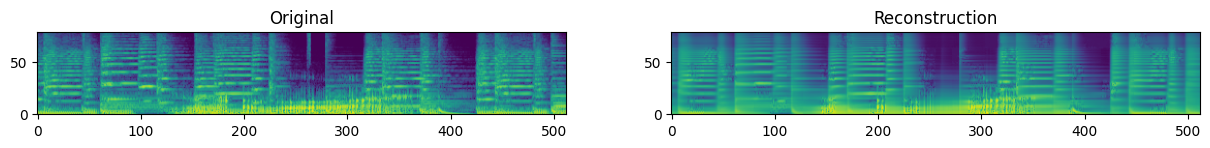

In [9]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1); plt.imshow(lms_cropped[0, 0], origin='lower'); plt.title('Original')
plt.subplot(1, 2, 2); plt.imshow(recons[0, 0], origin='lower'); plt.title('Reconstruction');